In [4]:
import pandas as pd

In [5]:
train_df = pd.read_csv("training/training.csv")
test_df = pd.read_csv("test/test.csv")

print(train_df.shape)
train_df.head()

(250000, 33)


,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


In [6]:
train_df.replace(-999.0, pd.NA, inplace=True)
test_df.replace(-999.0, pd.NA, inplace=True)

train_df.fillna(train_df.mean(numeric_only=True), inplace=True)
test_df.fillna(test_df.mean(numeric_only=True), inplace=True)

train_df.dropna(axis=1, thresh=int(0.9 * len(train_df)), inplace=True)
test_df.dropna(axis=1, thresh=int(0.9 * len(test_df)), inplace=True)

In [7]:
train_df["Label"] = train_df["Label"].str.strip().str.lower()
train_df["Label"] = train_df["Label"].map({'s': 1, 'b': 0})

feature_cols = [col for col in train_df.columns if col.startswith("DER_") or col.startswith("PRI_")]

X_train = train_df[feature_cols]
y_train = train_df["Label"]

X_test = test_df[feature_cols]

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use same scaler!

In [9]:
from sklearn.model_selection import train_test_split

X_full = X_train_scaled
y_full = train_df["Label"].values
weights_full = train_df["Weight"].values

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X_full, y_full, weights_full, test_size=0.2, random_state=42, stratify=y_full
)

## Training a Baseline Neural Network

In [10]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train, weight=w_train)
dtest = xgb.DMatrix(X_test, label=y_test, weight=w_test)

params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "max_depth": 6,
    "eta": 0.1,
    "verbosity": 0
}

bst = xgb.train(params, dtrain, num_boost_round=100)

xgb_probs = bst.predict(dtest)

In [11]:
from sklearn.metrics import accuracy_score, roc_auc_score

xgb_preds = (xgb_probs > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, xgb_preds))
print("AUC-ROC:", roc_auc_score(y_test, xgb_probs))

Accuracy: 0.65734
AUC-ROC: 0.8778918168308945


In [12]:
import numpy as np

def compute_ams(y_true, y_pred, weights, threshold=0.5, b_reg=10.0):
    y_pred_class = (y_pred > threshold).astype(int)
    
    s = weights[(y_true == 1) & (y_pred_class == 1)].sum()
    b = weights[(y_true == 0) & (y_pred_class == 1)].sum()
    
    ams = np.sqrt(2 * ((s + b + b_reg) * np.log(1.0 + s / (b + b_reg)) - s))
    return ams

In [15]:
ams = compute_ams(y_test, xgb_probs, w_test)
print(f"AMS Score: {ams:.4f}")

AMS Score: 0.0000


In [16]:
np.savez("xgb_results.npz", y_probs=xgb_probs, y_true=y_test)

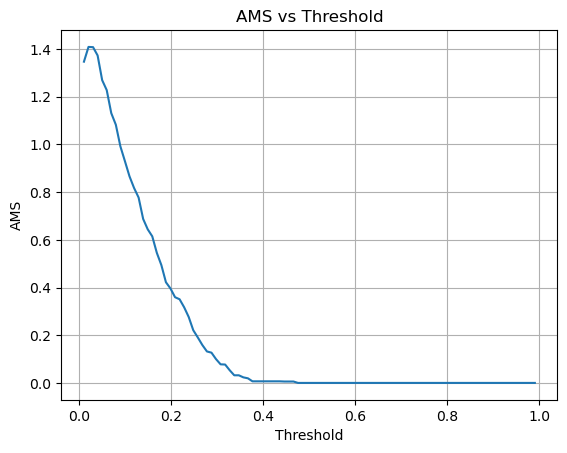

In [18]:
import matplotlib.pyplot as plt

thresholds = np.linspace(0.01, 0.99, 100)
ams_scores = [compute_ams(y_test, xgb_probs, w_test, threshold=t) for t in thresholds]

plt.plot(thresholds, ams_scores)
plt.xlabel("Threshold")
plt.ylabel("AMS")
plt.title("AMS vs Threshold")
plt.grid(True)
plt.show()

In [19]:
best_index = np.argmax(ams_scores)
best_threshold = thresholds[best_index]
best_ams = ams_scores[best_index]

print(f"Best AMS: {best_ams:.4f} at threshold = {best_threshold:.3f}")

Best AMS: 1.4088 at threshold = 0.020


**Here we can see that the XGBoost model is a lot more cautious than the dNN or sNN, with a very small threshold**

In [20]:
y_final_preds = (xgb_probs > best_threshold).astype(int)

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Accuracy:", accuracy_score(y_test, y_final_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_final_preds))
print(classification_report(y_test, y_final_preds))

Accuracy: 0.77258
Confusion Matrix:
 [[31806  1061]
 [10310  6823]]
              precision    recall  f1-score   support

           0       0.76      0.97      0.85     32867
           1       0.87      0.40      0.55     17133

    accuracy                           0.77     50000
   macro avg       0.81      0.68      0.70     50000
weighted avg       0.79      0.77      0.74     50000



<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

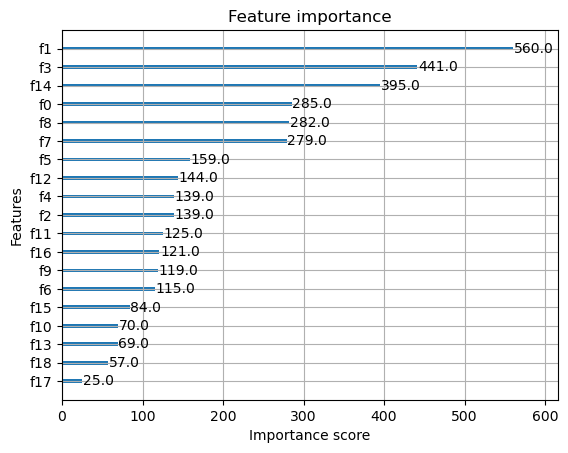

In [22]:
xgb.plot_importance(bst)